In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def gen_ar1(a, T, s = 1):
    X = np.zeros(T)
    X[0] = np.random.normal(0, s / max(0.01, np.sqrt(1 - a ** 2)))

    for t in range(1, T):
        X[t] = a * X[t - 1] + np.random.normal(0, s)
        
    return X

def exp_cost_ar(a_true, a_est, s = 1):
    return s + (a_true - a_est) ** 2 * 1 / (1 - a_true ** 2)

def exp_cost_model(a_true, a_est, a, s = 1):
    return s + (a_true - a_est) ** 2 * (1 / (1 - a ** 2) + a_true)

a = 0.8
T = 101
X_1 = gen_ar1(a, T)

In [3]:
def compute_bias(features, labels):
    
    T = np.shape(labels)[0]
    bias = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        ## full random variable
        bias.append(coefs * features_test * (2 * labels_test - coefs * features_test))
        
        ## part of random variable with non-zero mean
        # bias.append(-(coefs * features_test) ** 2)
        
        ## second part of second moment decomposition
        # bias.append(coefs * features_test)
    
    return np.mean(bias)

def cv_1d(features, labels):
    
    T = np.shape(labels)[0]
    cv_scores = []
    cv_scores_2 = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append((labels_test - features_test * coefs) ** 2)
        res = labels_test
        cv_scores_2.append(coefs * features_test * (2 * res - coefs * features_test))
        
    
    return np.mean(np.array(cv_scores)), np.mean(np.array(cv_scores_2))

def cv_nd(features, labels):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i, axis = 1), np.delete(labels, i)
        features_test, labels_test = features[:, i], labels[i]

        # train on del set
        coefs = np.linalg.inv(features_del @ features_del.T) @ features_del @ labels_del

        # test on test set
        cv_scores.append(((labels_test - features_test @ coefs) ** 2))

    return np.mean(np.array(cv_scores))

a_est = 1 / (np.dot(X_1[:-1], X_1[:-1].T)) * X_1[:-1] @ X_1[1:]

print(f"CV Using X1:\t\t{round(cv_1d(X_1[1:], X_1[:-1])[0], 4)}. MSE on X1:\t{1 / T * np.linalg.norm(X_1[1:] - a_est * X_1[:-1], 2) ** 2}")
print(f"CV Using true a:\t{1 / (T - 1) * np.linalg.norm(X_1[1:] - a * X_1[:-1], 2) ** 2}.")

CV Using X1:		1.1091. MSE on X1:	1.0816615927247786
CV Using true a:	1.102064340699519.


### AR(1)
We assume the data is generated as $$X_t = a_0X_{t - 1} + \varepsilon_t.$$
We generate and try the following hypothesis:
$$H_0: a = a_0,, \qquad H_1: a \neq a_0.$$
Under $H_0$, we have that $$CV(a_0) = \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - a_0X_{t-1}\right\rVert_2^2.$$

Under $H_1$, we have that $$CV(a) = \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - \hat{a}^{-t} X_{t-1}\right\rVert_2^2.$$

Where $$\hat{a}^{-t'} = \frac{\sum_{t = 1, t \neq t'}^{T - 1}X_tX_{t + 1}}{\sum_{t = 1, t \neq t'}^{T - 1}X_t^2}$$

In [4]:
a = 0.8
T = 1001
X = gen_ar1(a, T)

a_est = 1 / (np.dot(X[:-1], X[:-1].T)) * X[:-1] @ X[1:]

print(f"CV Using H0:\t{round(1 / (T - 1) * np.linalg.norm(X[1:] - a * X[:-1], 2) ** 2, 4)}.\n")
print(f"CV Using H1:\t{round(cv_1d(X[1:], X[:-1])[0], 4)}.")
print(f"MSE Using H1:\t{round(1 / (T - 1) * np.linalg.norm(X[1:] - a_est * X[:-1], 2) ** 2, 4)}")


CV Using H0:	0.9621.

CV Using H1:	0.9661.
MSE Using H1:	0.9617


In [9]:
iters = int(1e3)
a, T = 0.999, 101

def compare_cvs(a, T, iters = 10):
    
    count = 0

    for _ in range(iters):
        X_1 = gen_ar1(a, T)
        
        cv_a0 = 1 / (T - 1) * np.linalg.norm(X_1[1:] - a * X_1[:-1], 2) ** 2
        cv_a  = cv_1d(X_1[1:], X_1[:-1])[0]
    
        count += (cv_a0 < cv_a)

    return count / iters

compare_cvs(0.99, 251, 1000)

0.944

In [16]:
total_list = []

a_range = np.linspace(0.00, 0.99, 5)
T_range = [11, 21, 51, 101, 251]
iters = 2500

for T in T_range:
    print(f"{T}:", end = "\t")
    a_list = []
    for a in a_range:
        print(round(a, 2), end = "\t")
        a_list.append(compare_cvs(a, T, iters = iters))
    print(np.round(a_list, 2))
    total_list.append(a_list)
    print()
    
total_list = np.array(total_list)

11:	0.0	0.25	0.5	0.74	0.99	[0.71 0.69 0.72 0.73 0.78]

21:	0.0	0.25	0.5	0.74	0.99	[0.72 0.72 0.72 0.73 0.77]

51:	0.0	0.25	0.5	0.74	0.99	[0.72 0.71 0.74 0.73 0.75]

101:	0.0	0.25	0.5	0.74	0.99	[0.74 0.74 0.74 0.74 0.74]

251:	0.0	0.25	0.5	0.74	0.99	[0.73 0.73 0.74 0.74 0.74]



In [96]:
bckup = total_list.copy()

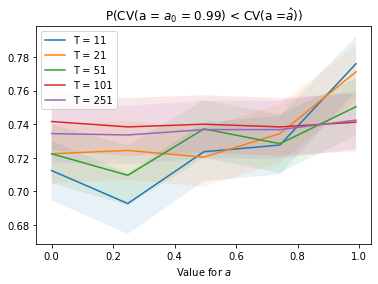

In [19]:
plt.xlabel(r"Value for $a$")
plt.title(fr"P(CV(a = $a_0$ = {a}) < CV(a =" + r"$\hat{a}$))")
for i, a_list in enumerate(total_list):
    plt.plot(a_range, a_list, label = f"T = {round(T_range[i], 2)}")
    plt.legend()
    
    dev = 1.96 * np.sqrt(np.array(a_list) * (1 - np.array(a_list)) / iters)
    plt.fill_between(a_range, a_list - dev, a_list + dev, alpha = 0.1)

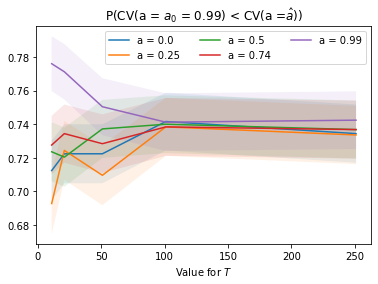

In [20]:
plt.xlabel(r"Value for $T$")
plt.title(fr"P(CV(a = $a_0$ = {a}) < CV(a =" + r"$\hat{a}$))")
for i, T_list in enumerate(np.array(total_list).T):
    T_list = np.array(T_list)
    plt.plot(T_range, T_list, label = f"a = {round(a_range[i], 2)}")
    plt.legend(ncol = 3)
    
    dev = 1.96 * np.sqrt(T_list * (1 - T_list) / iters)
    plt.fill_between(T_range, np.array(T_list) - dev, T_list + dev, alpha = 0.1)

Text(0.5, 1.0, '$P\\left(CV(a_0) < CV(\\hat{a})\\right)$')

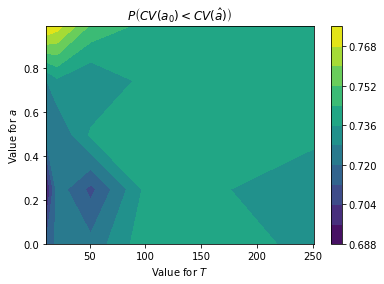

In [21]:
plt.xlabel(r"Value for $T$")
plt.ylabel(r"Value for $a$")
plt.contourf(T_range, a_range, np.array(total_list).T, levels = 10)
plt.colorbar()
plt.title(r"$P\left(CV(a_0) < CV(\hat{a})\right)$")

### Add offset

In [289]:
a = 0.75
T = 101
X = gen_ar1(a, T)

b = 5
X += b

b_est = np.mean(X)
X_m = X - b_est

a_est = 1 / (np.dot(X_m[:-1], X_m[:-1].T)) * X_m[:-1] @ X_m[1:]
a_est_true_b = 1 / (np.dot(X[:-1] - b, X[:-1].T - b)) * (X[:-1] - b) @ (X[1:] - b)

print(f"H_0: a = 0,\tb = {round(np.mean(X), 3)}.")
print(f"H_1: Estimate a and b.\t\ta = {round(a_est, 3)},\tb = {round(np.mean(X), 3)}.")
print(f"H_2: Estimate a, not b.\t\ta = {round(a_est_true_b, 3)},\tb = {round(b, 3)}.")
print(f"H_3: Estimate b, not a.\t\ta = {round(a, 3)},\tb = {round(b_est, 3)}.")
print(f"H_4: Not estimate a and b.\ta = {round(a, 3)},\tb = {round(b, 3)}.")

print(f"\nMSE(H_0):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - 0 * (X[:-1] - b_est), 2) ** 2, 3)}.")
print(f"MSE(H_1):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - a_est * (X[:-1] - b_est), 2) ** 2, 3)}.")
print(f"MSE(H_2):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b) - a_est_true_b * (X[:-1] - b), 2) ** 2, 3)}.")
print(f"MSE(H_3):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b_est) - a * (X[:-1] - b_est), 2) ** 2, 3)}.")
print(f"MSE(H_4):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b) - a * (X[:-1] - b), 2) ** 2, 3)}.")

print(f"\nCV(H_0):\t{round(cv_H0(X[:-1], X[1:], X), 3)}.")
print(f"CV(H_1):\t{round(cv_H1(X[:-1], X[1:], X), 3)}")
print(f"CV(H_2):\t{round(cv_H2(X[:-1], X[1:], b), 3)}")
print(f"CV(H_3):\t{round(cv_H3(X[:-1], X[1:], X, a), 3)}")
print(f"CV(H_4):\t{round(1 / (T - 1) * np.linalg.norm((X[1:] - b) - a * (X[:-1] - b), 2) ** 2, 3)}")

H_0: a = 0,	b = 4.525.
H_1: Estimate a and b.		a = 0.724,	b = 4.525.
H_2: Estimate a, not b.		a = 0.732,	b = 5.
H_3: Estimate b, not a.		a = 0.75,	b = 4.525.
H_4: Not estimate a and b.	a = 0.75,	b = 5.

MSE(H_0):	2.46.
MSE(H_1):	1.0.
MSE(H_2):	0.995.
MSE(H_3):	1.002.
MSE(H_4):	0.996.

CV(H_0):	2.505.
CV(H_1):	1.017
CV(H_2):	1.012
CV(H_3):	1.002
CV(H_4):	0.996


In [24]:
def cv_H0(features, labels, X):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        mean = np.mean(features_del)
        
        # train on test set
        cv_scores.append((labels_test - mean) ** 2)        
    
    return np.mean(np.array(cv_scores))

def cv_H1(features, labels, X):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        mean = np.mean(np.delete(X, i))
        
        features_m = features_del - mean
        labels_m = labels_del - mean
        
        # train on del set
        coefs = 1 / (features_m @ features_m.T) * features_m @ labels_m

        # train on test set
        cv_scores.append(((labels_test - mean) - (features_test - mean) * coefs) ** 2)        
    
    return np.mean(np.array(cv_scores))

def cv_H2(features, labels, b):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]
        
        features_m = features_del - b
        labels_m = labels_del - b
        
        # train on del set
        coefs = 1 / (features_m @ features_m.T) * features_m @ labels_m

        # train on test set
        cv_scores.append(((labels_test - b) - (features_test - b) * coefs) ** 2)        
    
    return np.mean(np.array(cv_scores))

def cv_H3(features, labels, X, a):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]
        
        mean = np.mean(np.delete(X, i))
        
        features_m = features_del - mean
        labels_m = labels_del - mean
        
        # train on del set
        coefs = a

        # train on test set
        cv_scores.append(((labels_test - mean) - (features_test - mean) * coefs) ** 2)        
    
    return np.mean(np.array(cv_scores))

In [116]:
a = 0.1
T = 10001
X_1 = gen_ar1(a, T)

b = 0.75
X_1 += b
X_1_m = X_1 - np.mean(X_1)

a_est = 1 / (np.dot(X_1_m[:-1], X_1_m[:-1].T)) * X_1_m[:-1] @ X_1_m[1:]
print(a_est)
print(f"CV Using X1:\t\t{round(cv_1d(X_1[1:], X_1[:-1])[0], 4)}.\tMSE on X1:\t{1 / (T - 1) * np.linalg.norm(X_1[1:] - a_est * X_1[:-1], 2) ** 2}")
print(f"CV Using true a:\t{round(1 / (T - 1) * np.linalg.norm((X_1[1:] - b) - a * (X_1[:-1] - b), 2) ** 2, 4)}.")

0.08783059506608382
CV Using X1:		1.2873.	MSE on X1:	1.440301642135166
CV Using true a:	0.9983.


In [23]:
def compare_H0_H1(a, b, T, iters = 10):
    
    count = 0

    for _ in range(iters):
        X = gen_ar1(a, T)
        X += b
        
        cv_h0_val = cv_H0(X[:-1], X[1:], X)
        cv_h1_val = cv_H1(X[:-1], X[1:], X)
    
        count += (cv_h0_val < cv_h1_val)

    return count / iters

In [307]:
# a = 0, b =/= 0, should pick H0, so expect closer to 1
print(compare_H0_H1(0.0, 12, 101, 100))

# a =/= 0, b = 0, should pick H1, so expect closer to 0.
print(compare_H0_H1(0.9, 0, 101, 100))

# a =/= 0, b =/= 0, should pick H1, so expect closer to 0.
print(compare_H0_H1(0.75, 12, 101, 100))

# a = 0, b = 0, should pick H0, so expect closer to 1.
print(compare_H0_H1(0.0, 0.0, 101, 100))

0.88
0.0
0.0
0.86


In [311]:
# probablity basically only depends on whether a is zero or not, b barely matters
# a = 0, b =/= 0, should pick H0, so expect closer to 1
print(compare_H0_H1(0.0, 12, 101, 100))
print(compare_H0_H1(0.05, 12, 101, 100))
print(compare_H0_H1(0.10, 12, 101, 100))
print(compare_H0_H1(0.15, 12, 101, 100))
print(compare_H0_H1(0.25, 12, 101, 100))

0.83
0.73
0.65
0.54
0.19


In [26]:
# probablity basically only depends on whether a is zero or not, b barely matters
# a = 0, b =/= 0, should pick H0, so expect closer to 1

print(compare_H0_H1(0.05, -50, 101, 100))
print(compare_H0_H1(0.05, -5, 101, 100))
print(compare_H0_H1(0.05, 0, 101, 100))
print(compare_H0_H1(0.05, 5, 101, 100))
print(compare_H0_H1(0.05, 50, 101, 100))

0.78
0.84
0.73
0.82
0.88


In [316]:
print(compare_H0_H1(0.05, -250, 101, 5000))
print(compare_H0_H1(0.05, -100, 101, 5000))
print(compare_H0_H1(0.05, 0, 101, 5000))
print(compare_H0_H1(0.05, 100, 101, 5000))
print(compare_H0_H1(0.05, 250, 101, 5000))

0.7816
0.7926
0.7876
0.7914
0.781


In [317]:
print(compare_H0_H1(0.05, np.random.choice(1000), 101, 5000))
print(compare_H0_H1(0.05, np.random.choice(1000), 101, 5000))
print(compare_H0_H1(0.05, np.random.choice(1000), 101, 5000))
print(compare_H0_H1(0.05, np.random.choice(1000), 101, 5000))
print(compare_H0_H1(0.05, np.random.choice(1000), 101, 5000))

0.8012
0.7876
0.7864
0.7892
0.7854


In [28]:
total_list_2 = []

a_range = [0.00, 0.05, 0.25, 0.50, 0.75, 0.99, 0.999]
T_range = [11, 21, 51, 101, 251]
iters = 500
b = 100

for T in T_range:
    print(f"{T}:", end = "\t")
    a_list = []
    for a in a_range:
        print(round(a, 2), end = "\t")
        a_list.append(compare_H0_H1(a, b, T, iters))
    print(np.round(a_list, 2))
    total_list_2.append(a_list)
    print()
    
total_list_2 = np.array(total_list_2)

11:	0.0	0.05	0.25	0.5	0.75	0.99	1.0	[0.85 0.83 0.77 0.53 0.42 0.21 0.21]

21:	0.0	0.05	0.25	0.5	0.75	0.99	1.0	[0.85 0.82 0.64 0.29 0.08 0.02 0.02]

51:	0.0	0.05	0.25	0.5	0.75	0.99	1.0	[0.8  0.81 0.38 0.02 0.   0.   0.  ]

101:	0.0	0.05	0.25	0.5	0.75	0.99	1.0	[0.83 0.8  0.17 0.   0.   0.   0.  ]

251:	0.0	0.05	0.25	0.5	0.75	0.99	1.0	[0.85 0.74 0.   0.   0.   0.   0.  ]



(5, 7)


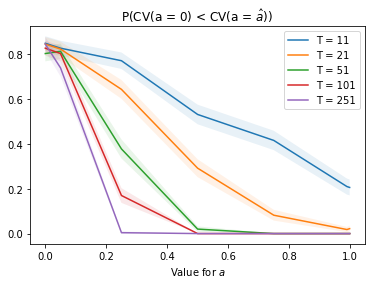

In [31]:
plt.xlabel(r"Value for $a$")
print(np.shape(total_list_2))
plt.title(r"P(CV(a = 0) < CV(a = $\hat{a}$))")
for i, a_list in enumerate(total_list_2):
    plt.plot(a_range, a_list, label = f"T = {round(T_range[i], 2)}")
    plt.legend()
    
    dev = 1.96 * np.sqrt(np.array(a_list) * (1 - np.array(a_list)) / iters)
    plt.fill_between(a_range, a_list - dev, a_list + dev, alpha = 0.1)

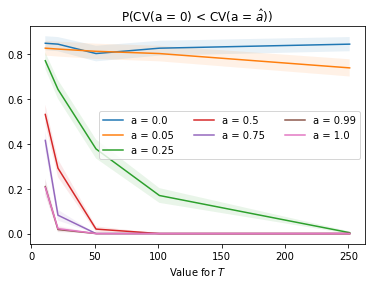

In [30]:
plt.xlabel(r"Value for $T$")
plt.title(r"P(CV(a = 0) < CV(a = $\hat{a}$))")
for i, T_list in enumerate(np.array(total_list_2).T):
    T_list = np.array(T_list)
    plt.plot(T_range, T_list, label = f"a = {round(a_range[i], 2)}")
    plt.legend(ncol = 3)
    
    dev = 1.96 * np.sqrt(T_list * (1 - T_list) / iters)
    plt.fill_between(T_range, np.array(T_list) - dev, T_list + dev, alpha = 0.1)

In [32]:
def compare_H1_H3(a, b, T, iters = 10):
    
    count = 0

    for _ in range(iters):
        X = gen_ar1(a, T)
        X += b
        
        cv_h1_val = cv_H1(X[:-1], X[1:], X)      # h1: a = \hat{a}, b = \hat{b}
        cv_h3_val = cv_H3(X[:-1], X[1:], X, a)   # h3: a = a,       b = \hat{b}
    
        count += (cv_h3_val < cv_h1_val)

    return count / iters

In [41]:
# a = 0, b =/= 0, should pick H0, so expect closer to 1
print(compare_H1_H3(0.9, 0.0, 100, 1000))

0.786


In [33]:
# a = 0, b =/= 0, should pick H0, so expect closer to 1
print(compare_H1_H3(0.0, 12, 101, 100))

# a =/= 0, b = 0, should pick H1, so expect closer to 0.
print(compare_H1_H3(0.9, 0, 101, 100))

# a =/= 0, b =/= 0, should pick H1, so expect closer to 0.
print(compare_H1_H3(0.75, 12, 101, 100))

# a = 0, b = 0, should pick H0, so expect closer to 1.
print(compare_H1_H3(0.0, 0.0, 101, 100))

0.83
0.81
0.84
0.85


In [34]:
total_list_2 = []

a_range = [0.00, 0.15, 0.25, 0.50, 0.75, 0.99, 0.999]
T_range = [11, 21, 51, 101, 251]
iters = 500
b = 100

for T in T_range:
    print(f"{T}:", end = "\t")
    a_list = []
    for a in a_range:
        print(round(a, 2), end = "\t")
        a_list.append(compare_H1_H3(a, b, T, iters))
    print(np.round(a_list, 2))
    total_list_2.append(a_list)
    print()
    
total_list_2 = np.array(total_list_2)

11:	0.0	0.15	0.25	0.5	0.75	0.99	1.0	[0.87 0.87 0.84 0.81 0.74 0.49 0.47]

21:	0.0	0.15	0.25	0.5	0.75	0.99	1.0	[0.84 0.82 0.83 0.8  0.77 0.49 0.42]

51:	0.0	0.15	0.25	0.5	0.75	0.99	1.0	[0.82 0.84 0.84 0.85 0.82 0.49 0.41]

101:	0.0	0.15	0.25	0.5	0.75	0.99	1.0	[0.84 0.85 0.83 0.85 0.84 0.5  0.44]

251:	0.0	0.15	0.25	0.5	0.75	0.99	1.0	[0.85 0.85 0.83 0.81 0.86 0.61 0.45]



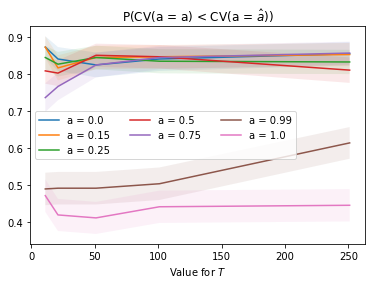

In [35]:
plt.xlabel(r"Value for $T$")
plt.title(r"P(CV(a = a) < CV(a = $\hat{a}$))")
for i, T_list in enumerate(np.array(total_list_2).T):
    T_list = np.array(T_list)
    plt.plot(T_range, T_list, label = f"a = {round(a_range[i], 2)}")
    plt.legend(ncol = 3)
    
    dev = 1.96 * np.sqrt(T_list * (1 - T_list) / iters)
    plt.fill_between(T_range, np.array(T_list) - dev, T_list + dev, alpha = 0.1)

(5, 7)


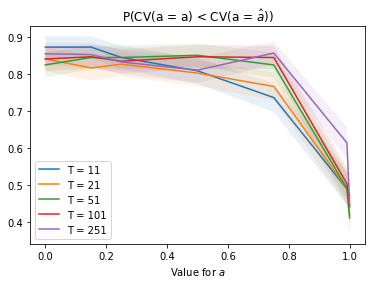

In [37]:
plt.xlabel(r"Value for $a$")
print(np.shape(total_list_2))
plt.title(r"P(CV(a = a) < CV(a = $\hat{a}$))")
for i, a_list in enumerate(total_list_2):
    plt.plot(a_range, a_list, label = f"T = {round(T_range[i], 2)}")
    plt.legend()
    
    dev = 1.96 * np.sqrt(np.array(a_list) * (1 - np.array(a_list)) / iters)
    plt.fill_between(a_range, a_list - dev, a_list + dev, alpha = 0.1)